In [1]:
#!pip install qiskit
#!pip install qiskit_machine_learning
#!pip install pylatexenc

In [2]:
#Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B,SLSQP,ADAM

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError
import pylatexenc

from sklearn.metrics import confusion_matrix

In [3]:
#Initiating the instance
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024)

In [4]:
#Reading the data and removing extra column unnamed
data = pd.read_csv("outputNH3.csv")
data.head()
data = data.drop("Unnamed: 0", axis = 1)
data.head()

,BOD,NH3-N,TN,MLSS,PH,AT_Temp,NH3_Y,Date
0,38,25,48,2250,8.3,22.150,0.98,2013-01-10 00:00:00
1,150,28,41,2190,7.4,22.975,0.59,2013-01-24 00:00:00
2,130,26,41,2090,7.2,22.750,0.57,2013-01-31 00:00:00
3,180,29,48,2500,7.6,25.200,0.78,2013-02-07 00:00:00
4,170,28,44,2040,7.3,24.175,0.72,2013-03-07 00:00:00


In [5]:
#Filtering data so it runs faster
data = data.iloc[0:10,]

In [6]:
# Creating a binary variable based on median value
#data['NH3_Y_binary'] = np.where(data['NH3_Y'] >= data['NH3_Y'].median(), 1, 0)
data['NH3_Y_binary'] = data['NH3-N']/data['NH3-N'].max()
data.head()

,BOD,NH3-N,TN,MLSS,PH,AT_Temp,NH3_Y,Date,NH3_Y_binary
0,38,25,48,2250,8.3,22.150,0.98,2013-01-10 00:00:00,0.862069
1,150,28,41,2190,7.4,22.975,0.59,2013-01-24 00:00:00,0.965517
2,130,26,41,2090,7.2,22.750,0.57,2013-01-31 00:00:00,0.896552
3,180,29,48,2500,7.6,25.200,0.78,2013-02-07 00:00:00,1.000000
4,170,28,44,2040,7.3,24.175,0.72,2013-03-07 00:00:00,0.965517


In [7]:
#Filtering relevant independent variables
X = data[['BOD','NH3-N','TN','MLSS','PH','AT_Temp']]
X.head()

,BOD,NH3-N,TN,MLSS,PH,AT_Temp
0,38,25,48,2250,8.3,22.150
1,150,28,41,2190,7.4,22.975
2,130,26,41,2090,7.2,22.750
3,180,29,48,2500,7.6,25.200
4,170,28,44,2040,7.3,24.175


In [8]:
# Creating binary variable
y = data['NH3_Y_binary']

In [9]:
# construct QNN
num_inputs = 6
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [10]:
# construct feature map
feature_map = ZFeatureMap(num_inputs)
# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=2)


VQC Regression

In [11]:
#Initiating regressor
vqr = VQR(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=SLSQP(),
          quantum_instance=quantum_instance)

In [12]:
#fitting regressor
vqr.fit(X, y)

In [13]:
#Predicting the value
y_VQR = vqr.predict(X)
y_VQR

array([[0.80078125],
       [0.79101562],
       [0.859375  ],
       [0.83007812],
       [0.86132812],
       [0.765625  ],
       [0.71875   ],
       [0.6171875 ],
       [0.70898438],
       [0.68359375]])

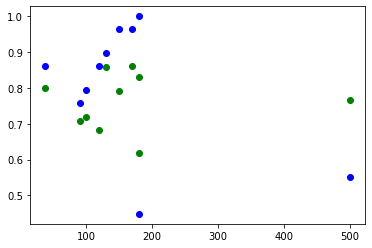

In [14]:
# plot data
plt.plot(X.iloc[:,0], y, 'bo')
# plot fitted line
plt.plot(X.iloc[:,0], y_VQR, 'go')
plt.show()

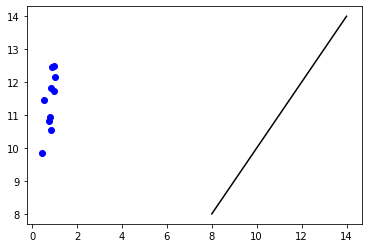

In [20]:
y_VQR_b = np.interp(y_VQR, (y.min(), y.max()), (8, 14))
plt.plot(y,y_VQR_b, 'bo')
x = np.linspace(8, 14,100)
plt.plot(x,x,color="black")

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#MSE
mse = mean_squared_error(y,y_VQR)
print(mse)
# R squared error
r2s = r2_score(y,y_VQR)
print(r2s)

0.018944824436473506
0.36396816961779577
